In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
color = sns.color_palette()
%matplotlib inline
matplotlib.style.use('ggplot')

from collections import Counter

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# my own module
from conf.configure import Configure
import kmeans_impute_missing_data as impute
import impute_missing_data

In [2]:
train = pd.read_csv(Configure.original_train_path)
test = pd.read_csv(Configure.original_test_path)

In [3]:
train.shape, test.shape

((30471, 292), (7662, 291))

In [4]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


** price_doc **

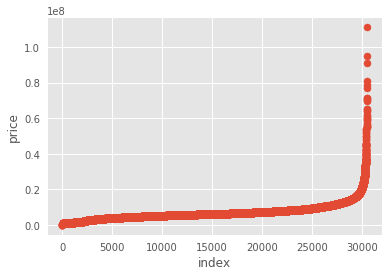

In [5]:
plt.figure(figsize=(6,4))
plt.scatter(range(train.shape[0]), np.sort(train.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

In [6]:
train['yearmonth'] = train['timestamp'].apply(lambda x: x[:4]+x[5:7])
test['yearmonth'] = test['timestamp'].apply(lambda x: x[:4]+x[5:7])

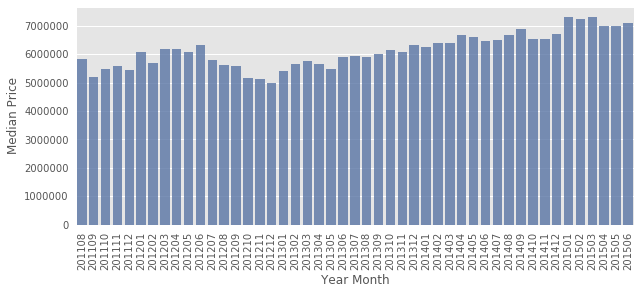

In [7]:
grouped_df = train.groupby(['yearmonth'])['price_doc'].aggregate('median').reset_index()

plt.figure(figsize=(10,4))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[0])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

可以看出 201108 到 201211 房价波动，之后呈现基本的线形增长的趋势，可以结合宏观经济进行分析

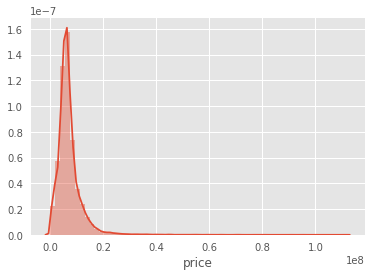

In [8]:
# price_doc 的价格分布
plt.figure(figsize=(6,4))
sns.distplot(train.price_doc.values, bins=60, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

可以看出价格呈现长尾分布，需要进行 `log(p+1)` 转换

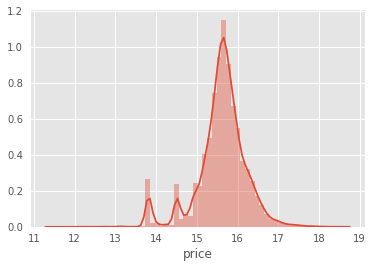

In [9]:
train['price_doc'] = np.log1p(train['price_doc'])
plt.figure(figsize=(6,4))
sns.distplot(train.price_doc.values, bins=60, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

** missing values in each column **

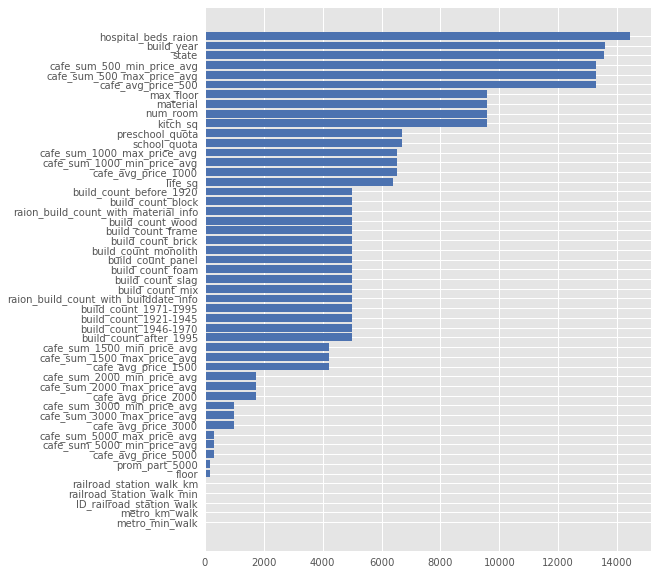

In [10]:
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df.missing_count > 0]
missing_df = missing_df.sort_values(by='missing_count')
ind = np.arange(missing_df.shape[0])
fig, ax = plt.subplots(figsize=(8,10))
ax.barh(ind, missing_df.missing_count.values, color=color[0])
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal');

缺失数据存在分组的现象，填充缺失数据时可以进行分组分析

## 填充缺失值（数值类型）

In [11]:
def simple_filling_missing_data(dataframe, columns, value):
    """ 填充缺失数据 """
    for column in columns:
        dataframe.loc[dataframe[column].isnull(), column] = value


def simple_impute_data(train, test):
    simple_filling_missing_data(train, ['build_year'], 0)
    simple_filling_missing_data(test, ['build_year'], 0)

def impute_categories_missing_data(dataframe, cate_columns):
    for column in cate_columns:
        most_common = Counter(dataframe[column].tolist()).most_common(1)[0][0]
        dataframe.loc[dataframe[column].isnull(), column] = most_common

In [12]:
simple_impute_data(train, test)

In [13]:
# 合并训练集和测试集
conbined_data = pd.concat([train[test.columns.values], test])
conbined_data.columns = test.columns.values
train_price_doc = train['price_doc']
print train.shape, test.shape, conbined_data.shape

(30471, 293) (7662, 292) (38133, 292)


In [14]:
str_columns = conbined_data.select_dtypes(include=['object']).columns.values.tolist()
num_columns = conbined_data.select_dtypes(exclude=['object']).columns.values.tolist()

In [15]:
# 去除类别属性的数值类型的 column
num_columns.remove('id')
num_columns.remove('material')
num_columns.remove('state')
num_columns.remove('build_year')


**KMeans 算法填充缺失数据, n_clusters 为超参数！**

In [16]:
missing_rates = [0.5, 0.4, 0.3, 0.2, 0.1, 0]
kmeans_impute_data = conbined_data[num_columns].copy()
total_count = conbined_data.shape[0]
for missing_rate in missing_rates:
    missing_df = conbined_data[num_columns].isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df[missing_df.missing_count > 0]
    
    if missing_df.shape[0] == 0:
        break
        
    missing_df = missing_df.sort_values(by='missing_count', ascending=False)
    missing_df['missing_rate'] = 1.0*missing_df['missing_count'] / total_count
    if missing_df['missing_rate'].values[0] < missing_rate:
        continue

    print '填充缺失率大于{}的数据, 缺失数据属性 {}...'.format(missing_rate, missing_df.shape[0])
    # n_clusters 为超参数！
    impute_model = impute.KMeansImputeMissingData(conbined_data[num_columns], n_clusters=20, max_iter=100)
    kmeans_labels, x_kmeans, centroids, global_labels, x_global_mean = impute_model.impute_missing_data()
    
    kmeans_impute_data[num_columns] = x_kmeans
    # 填充数据
    big_missing_columns = missing_df[missing_df.missing_rate > missing_rate]['column_name']
    conbined_data[big_missing_columns] = kmeans_impute_data[big_missing_columns]
    
    missing_df = conbined_data[num_columns].isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df[missing_df.missing_count > 0]
    print '缺失数据属性 {}'.format(missing_df.shape[0])
    

填充缺失率大于0.4的数据, 缺失数据属性 49...
perform iter: 0
perform iter: 1
perform iter: 2
perform iter: 3
perform iter: 4
cluster converged!
缺失数据属性 45
填充缺失率大于0.2的数据, 缺失数据属性 45...
perform iter: 0
perform iter: 1
cluster converged!
缺失数据属性 37
填充缺失率大于0.1的数据, 缺失数据属性 37...
perform iter: 0
perform iter: 1
cluster converged!
缺失数据属性 17
填充缺失率大于0的数据, 缺失数据属性 17...
perform iter: 0
perform iter: 1
cluster converged!
缺失数据属性 0


In [17]:
train = conbined_data.iloc[:train.shape[0], :]
train['price_doc'] = train_price_doc
test = conbined_data.iloc[train.shape[0]:, :]
print train.shape, test.shape

(30471, 293) (7662, 292)


** full_sq、 life_sq 和 kitch_sq 字段 **

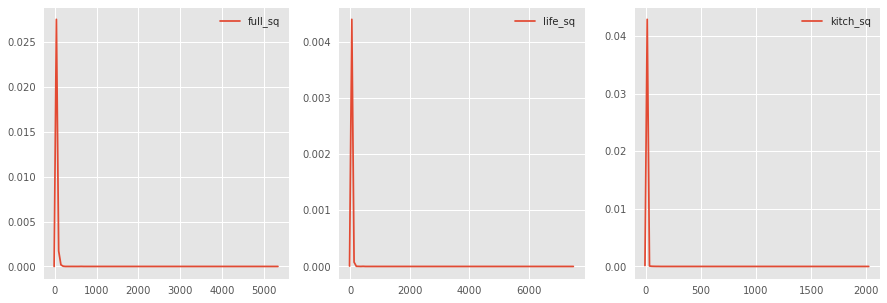

In [18]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
sns.kdeplot(train['full_sq'])
ax = plt.subplot(132)
sns.kdeplot(train['life_sq'],ax=ax)
ax = plt.subplot(133)
sns.kdeplot(train['kitch_sq'],ax=ax)
plt.show()

In [19]:
sum(train['kitch_sq'] > train['full_sq']), sum(train['life_sq'] > train['full_sq'])

(14, 790)

In [20]:
# 去除 life_sq > full_sq 和 kitch_sq > full_sq 的异常数据
print train.shape
train = train[train['kitch_sq'] <= train['full_sq']]
# train = train[train['life_sq'] <= train['full_sq']]
print train.shape

(30471, 293)
(30457, 293)


In [21]:
print '最大值：', test['full_sq'].max(), train['full_sq'].max()
print '训练集中 full_sq 大于测试集的最大值的数据个数：', train[train['full_sq'] > test['full_sq'].max()].shape[0]

最大值： 403.0 5326.0
训练集中 full_sq 大于测试集的最大值的数据个数： 9


In [22]:
gap = 50
# 去除训练集中出现的数据而测试集中没有出现的数据避免过拟合
print train.shape
train = train[train['full_sq'] <= test['full_sq'].max() + gap]
print train.shape
train = train[train['life_sq'] <= test['life_sq'].max() + gap]
print train.shape

(30457, 293)
(30450, 293)
(30449, 293)


In [23]:
# 添加面积比例
train['life_sq_ratio'] = train['life_sq'] / (train['full_sq'] + 1)
train['kitch_sq_ratio'] = train['kitch_sq'] / (train['full_sq'] + 1)
train['kitch_sq_vs_life_ratio'] = train['kitch_sq'] / (train['life_sq'] + 1)

test['life_sq_ratio'] = test['life_sq'] / (test['full_sq'] + 1)
test['kitch_sq_ratio'] = test['kitch_sq'] / (test['full_sq'] + 1)
test['kitch_sq_vs_life_ratio'] = test['kitch_sq'] / (test['life_sq'] + 1)

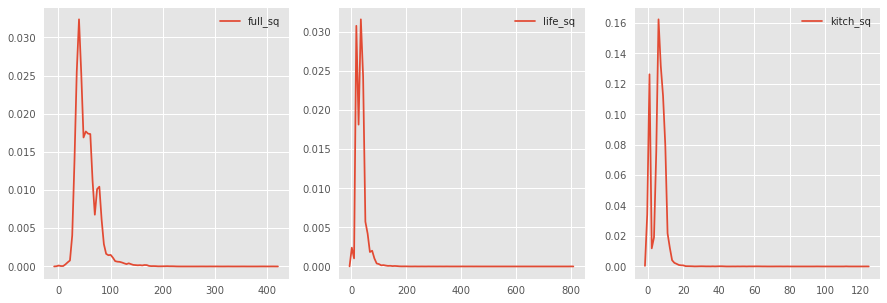

In [24]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
sns.kdeplot(train['full_sq'])
ax = plt.subplot(132)
sns.kdeplot(train['life_sq'],ax=ax)
ax = plt.subplot(133)
sns.kdeplot(train['kitch_sq'],ax=ax)
plt.show()

In [25]:
# log1p 处理
train['full_sq'] = np.log1p(train['full_sq'])
test['full_sq'] = np.log1p(test['full_sq'])

train['life_sq'] = np.log1p(train['life_sq'])
test['life_sq'] = np.log1p(test['life_sq'])

train['kitch_sq'] = np.log1p(train['kitch_sq'])
test['kitch_sq'] = np.log1p(test['kitch_sq'])

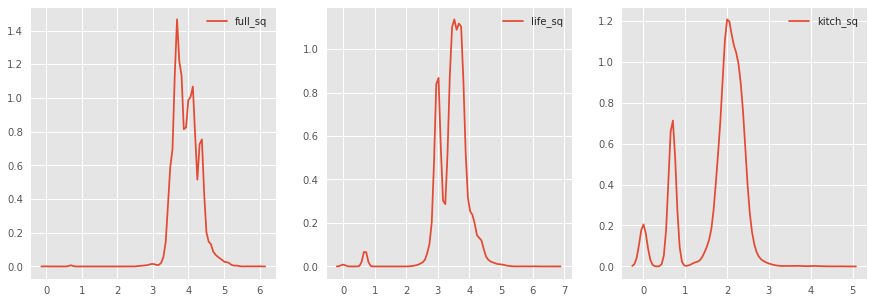

In [26]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
sns.kdeplot(train['full_sq'])
ax = plt.subplot(132)
sns.kdeplot(train['life_sq'],ax=ax)
ax = plt.subplot(133)
sns.kdeplot(train['kitch_sq'],ax=ax)
plt.show()

In [27]:
print train.shape, test.shape

(30449, 296) (7662, 295)


** floor 和 max_floor 字段 **

In [28]:
train['floor'] = train['floor'].map(lambda f: int(round(f)))
train['max_floor'] = train['max_floor'].map(lambda f: int(round(f)))

test['floor'] = test['floor'].map(lambda f: int(round(f)))
test['max_floor'] = test['max_floor'].map(lambda f: int(round(f)))

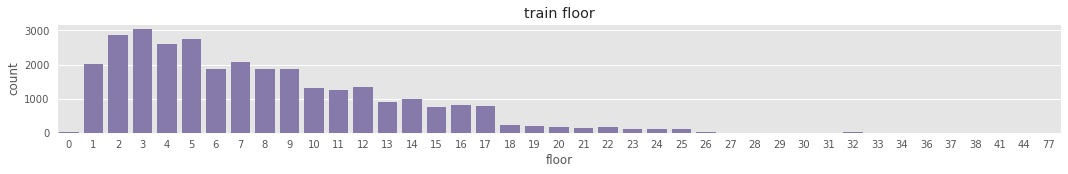

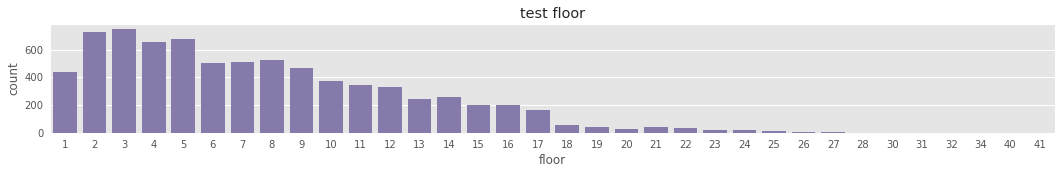

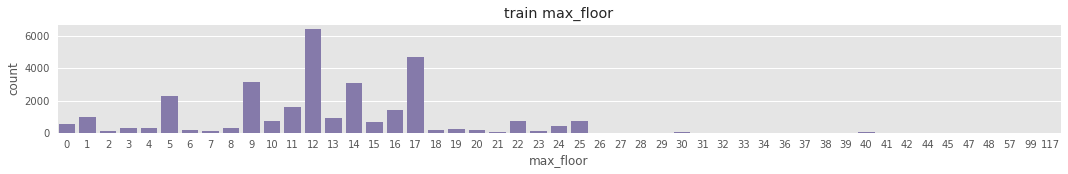

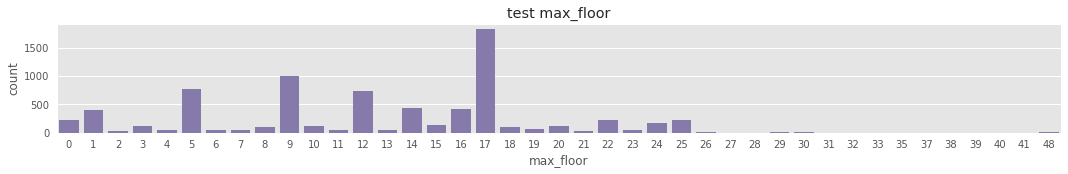

In [29]:
plt.figure(figsize=(18,2))
sns.countplot(train['floor'], color=color[3])
plt.title('train floor')
plt.figure(figsize=(18,2))
sns.countplot(test['floor'], color=color[3])
plt.title('test floor')
plt.figure(figsize=(18,2))
sns.countplot(train['max_floor'], color=color[3])
plt.title('train max_floor')
plt.figure(figsize=(18,2))
sns.countplot(test['max_floor'], color=color[3])
plt.title('test max_floor')
plt.show()

可以看出 floor 和 max_floor 的分布基本一致。

** material 字段 **

In [30]:
print train['material'].isnull().sum(), test['material'].isnull().sum()
set(test['material'])

9566 0


{1.0, 2.0, 3.0, 4.0, 5.0, 6.0}

In [31]:
simple_filling_missing_data(train, ['material'], 0)
simple_filling_missing_data(test, ['material'], 0)

In [32]:
train['material'] = train['material'].map(lambda f: int(f))
test['material'] = test['material'].map(lambda f: int(f))

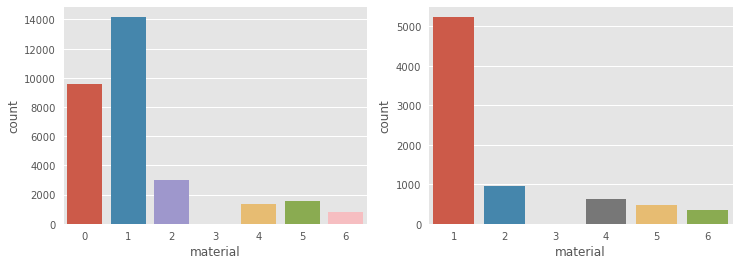

In [33]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.countplot(train['material'], ax=ax)
ax = plt.subplot(122)
sns.countplot(test['material'], ax=ax)
plt.show()

** build_year 字段 **

In [34]:
train['build_year'] = train['build_year'].map(lambda x: int(x))
test['build_year'] = test['build_year'].map(lambda x: int(x))

In [35]:
train['build_year'].min(), train['build_year'].max(), test['build_year'].min(), test['build_year'].max()

(0, 20052009, 0, 2019)

In [36]:
train['build_year'][train['build_year'] > test['build_year'][test['build_year'] > 0].max()]

10089    20052009
15220        4965
Name: build_year, dtype: int64

In [37]:
# 去除训练集中 build_year 异常的数据
train = train[train['build_year'] <= test['build_year'][test['build_year'] > 0].max()]
print train.shape

(30447, 296)


In [38]:
train['build_year'].max()

2018

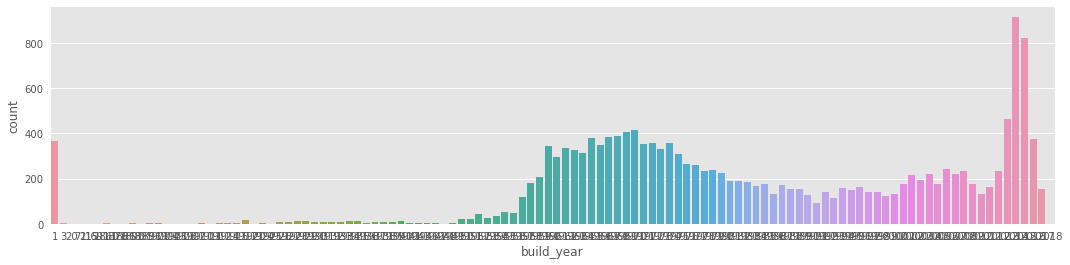

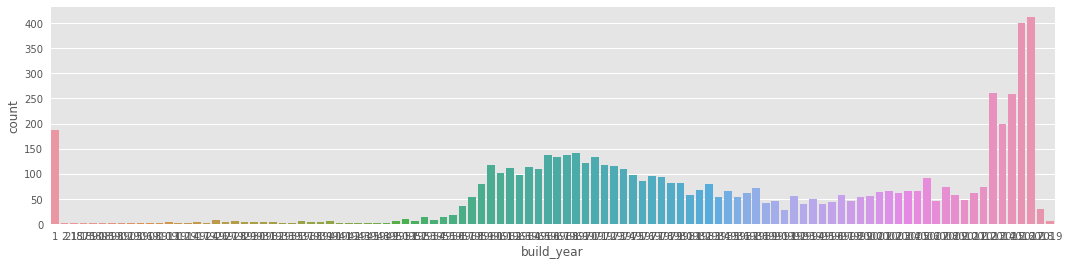

In [39]:
plt.figure(figsize=(18,4))
sns.countplot(train['build_year'][train['build_year'] > 0])
plt.figure(figsize=(18,4))
sns.countplot(test['build_year'][test['build_year'] > 0])
plt.show()

build_year 分布基本一致

** num_room 字段 ** number of living rooms

In [40]:
train['num_room'] = train['num_room'].map(lambda x: int(round(x)))
test['num_room'] = test['num_room'].map(lambda x: int(round(x)))

In [41]:
print sum(train['num_room'] == 0), sum(test['num_room'] == 0)
# num_room 数目为0，但 life_sq 不为0，所以 num_room = 0表示缺失数据
# train['life_sq'][train['num_room'] == 0]
train.loc[train['num_room'] == 0, 'num_room'] = 2
test.loc[test['num_room'] == 0, 'num_room'] = 2

14 0


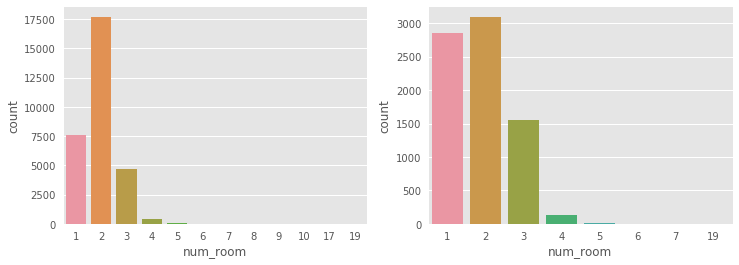

In [42]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.countplot(train['num_room'], ax=ax)
ax = plt.subplot(122)
sns.countplot(test['num_room'], ax=ax)
plt.show()

In [43]:
train['per_living_room_sq'] = train['life_sq'] / train['num_room']
test['per_living_room_sq'] = test['life_sq'] / test['num_room']

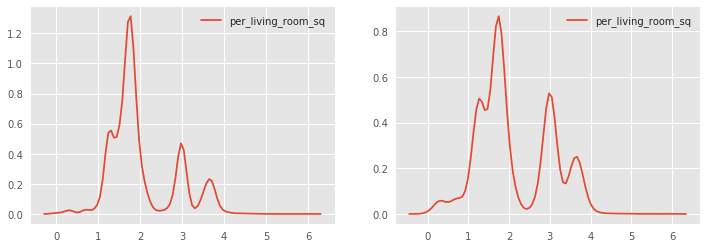

In [44]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.kdeplot(train['per_living_room_sq'], ax=ax)
ax = plt.subplot(122)
sns.kdeplot(test['per_living_room_sq'], ax=ax)
plt.show()

** state 字段**

In [45]:
print train['state'].isnull().sum(), test['state'].isnull().sum()
print 'train state 缺失率：', (1.0*train['state'].isnull().sum()) / train.shape[0]
print 'test state 缺失率：', (1.0*test['state'].isnull().sum()) / test.shape[0]

13551 694
train state 缺失率： 0.445068479653
test state 缺失率： 0.0905768728791


In [46]:
simple_filling_missing_data(train, ['state'], -1)
simple_filling_missing_data(test, ['state'], -1)
train['state'] = train['state'].map(lambda x: int(x))
test['state'] = test['state'].map(lambda x: int(x))

In [47]:
set(train['state']), set(test['state'])

({-1, 1, 2, 3, 4}, {-1, 1, 2, 3, 4})

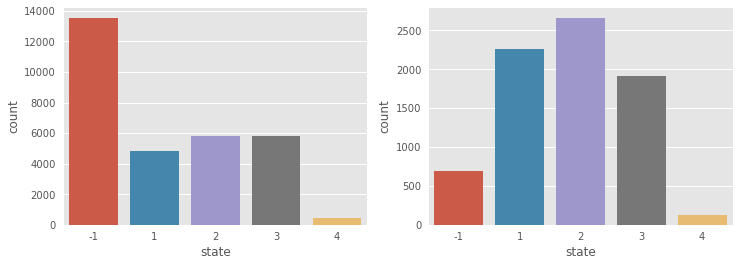

In [48]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.countplot(train['state'], ax=ax)
ax = plt.subplot(122)
sns.countplot(test['state'], ax=ax)
plt.show()

** product_type 字段**

In [49]:
print train['product_type'].isnull().sum(), test['product_type'].isnull().sum()

0 33


In [50]:
impute_categories_missing_data(train, ['product_type'])
impute_categories_missing_data(test, ['product_type'])

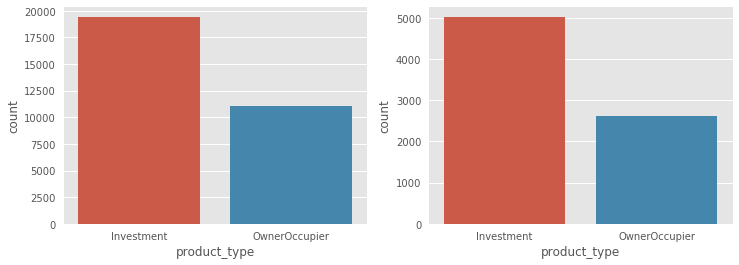

In [51]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.countplot(train['product_type'], ax=ax)
ax = plt.subplot(122)
sns.countplot(test['product_type'], ax=ax)
plt.show()

**sub_area字段**
name of the district

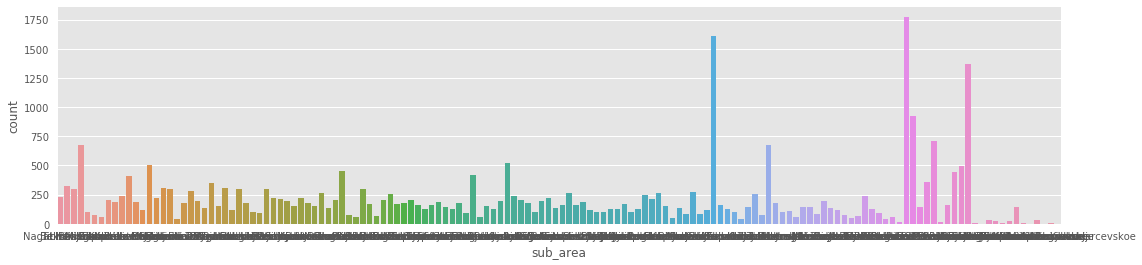

In [61]:
plt.figure(figsize=(18,4))
sns.countplot(train['sub_area'])

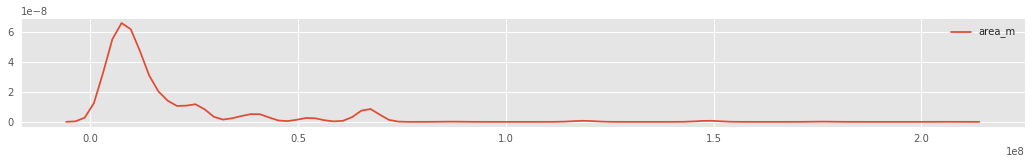

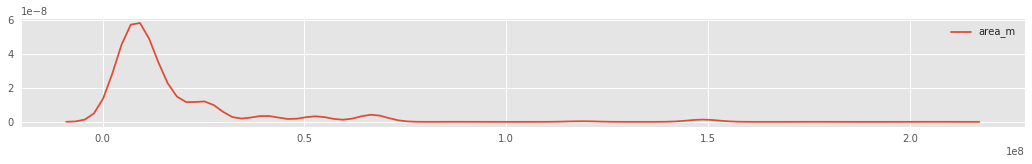

In [73]:
plt.figure(figsize=(18,2))
sns.kdeplot(train['area_m'])
plt.figure(figsize=(18,2))
sns.kdeplot(test['area_m'])

**raion_popul 直辖市人口数**

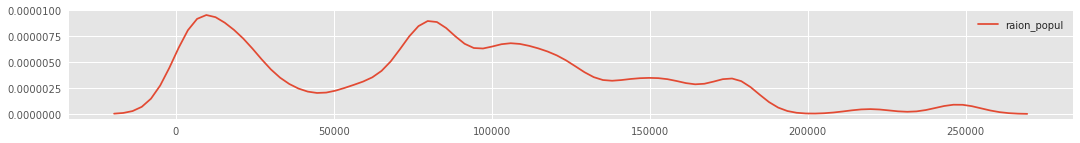

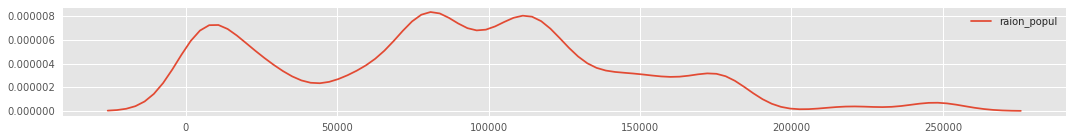

In [74]:
plt.figure(figsize=(18,2))
sns.kdeplot(train['raion_popul'])
plt.figure(figsize=(18,2))
sns.kdeplot(test['raion_popul'])

In [107]:
set(conbined_data['ID_bus_terminal'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

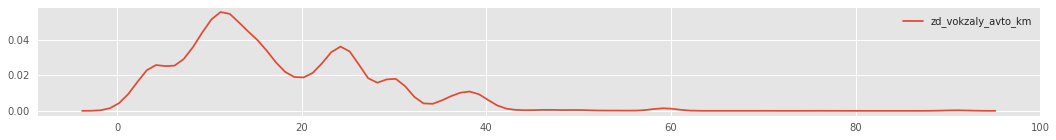

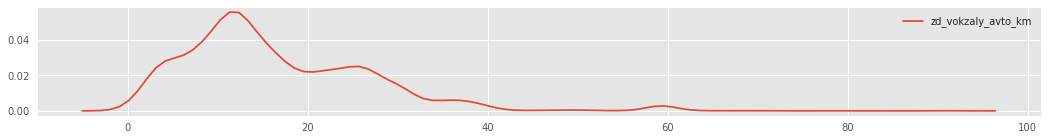

In [103]:
plt.figure(figsize=(18,2))
sns.kdeplot(train['zd_vokzaly_avto_km'])
plt.figure(figsize=(18,2))
sns.kdeplot(test['zd_vokzaly_avto_km'])

```
id
timestamp
full_sq
life_sq
floor
max_floor
material
build_year
num_room
kitch_sq
state
product_type
sub_area                              地区名称

# Complete description of neighbourhood features

area_m                                周边面积
raion_popul                           直辖市人口数
green_zone_part                       绿地面积比例
indust_part                           工业区占总面积的比重

children_preschool                    学龄前人口数
preschool_quota                       学前教育机构的座位数
children_school                       学龄儿童人口
school_quota                          地区中学座位数
preschool_education_centers_raion     学前教育机构数量
school_education_centers_raion        高中院校数
school_education_centers_top_20_raion 莫斯科20所最好学校的高中人数
university_top_20_raion               联邦排名前十位的高等教育机构
sport_objects_raion                   高等教育机构数量
additional_education_raion            额外教育机构数目

hospital_beds_raion                   各区医院病床数目
healthcare_centers_raion              地区医疗中心数

culture_objects_top_25                存在的主要对象的文化遗产top25
culture_objects_top_25_raion          文化遗产对象数
shopping_centers_raion                区内商场及购物中心数
office_raion                          区内办公中心数
thermal_power_plant_raion             小区热电站的存在
incineration_raion                    存在焚烧炉
oil_chemistry_raion                   肮脏工业的存在
radiation_raion                       放射性废物处置存在
railroad_terminal_raion               区内铁路枢纽的存在
big_market_raion                      大型杂货/批发市场的存在
nuclear_reactor_raion                 现有核反应堆的存在
detention_facility_raion              监狱拘留中心的存在

full_all                              全市人口总数
male_f                                全市男性人口
female_f                              全市女性人口
young_all                             小于工作年龄的人口
young_male                            小于工龄的男性人口
young_female                          小于工龄的女性人口
work_all                              劳动年龄人口
work_male                             劳动年龄男性人口
work_female                           劳动年龄男性人口
ekder_all                             年龄大于工作年龄的人口
ekder_male                            年龄大于工作年龄的男性人口
ekder_female                          年龄大于工作年龄的女性人口
0_6_all
0_6_male
0_6_female
7_14_all
7_14_male
7_14_female
0_17_all
0_17_male
0_17_female
16_29_all
16_29_male
16_29_female
0_13_all
0_13_male
0_13_female


raion_build_count_with_material_info  小区内有物料信息的建筑数量
build_count_block                     砌块建筑占有率
build_count_wood                      木建筑占有率
build_count_frame                     框架建筑占有率
build_count_brick                     砖建筑占有率
build_count_monolith                  整体柱建筑占有率
build_count_panel                     面板建筑占有率
build_count_foam                      泡沫建筑占有率
build_count_slag                      渣土建筑占有率
build_count_mix                       混合建筑物占有率
raion_build_count_with_builddate_info 小区内包含建年信息的建筑数量
build_count_before_1920
build_count_1921-1945
build_count_1946-1970
build_count_1971-1995
build_count_after_1995
ID_metro
metro_min_avto                        乘车到地铁的时间，分钟
metro_km_avto                         到地铁的行驶距离，km
metro_min_walk                        步行到地铁的时间，分钟
metro_km_walk                         到地铁的步行距离，km
kindergarten_km                       距离幼儿园
school_km                             距离学校
park_km                               距离公园
green_zone_km                         距离绿区
industrial_km                         距离工业区
water_treatment_km                    水处理距离
cemetery_km                           墓地距离
incineration_km                       焚烧地距离
railroad_station_walk_km              Distance to the railroad station (walk)
railroad_station_walk_min             Time to the railroad station (walk)
ID_railroad_station_walk              Nearest railroad station id (walk)
railroad_station_avto_km              Distance to the railroad station (avto)
railroad_station_avto_min             Time to the railroad station (avto)
ID_railroad_station_avto              Nearest railroad station id (avto)
public_transport_station_km           Distance to the public transport station (walk)
public_transport_station_min_walk     Time to the public transport station (walk)
water_km                              到水库/河的距离
water_1line                           First line to the river (150 m)
mkad_km                               Distance to MKAD (Moscow Circle Auto Road)
ttk_km                                Distance to the TTC (Third Transport Ring)
sadovoe_km                            Distance to the Garden Ring
bulvar_ring_km                        The distance to the Boulevard Ring
kremlin_km                            Distance to the city center (Kremlin)
big_road1_km                          Distance to Nearest major road
ID_big_road1                          Nearest big road id
big_road1_1line                       First line to the road (100 m for highwys, 250 m to MKAD)
big_road2_km                          The distance to next distant major road
ID_big_road2                          2nd nearest big road id
railroad_km                           Distance to the railway / Moscow Central Ring / open areas Underground
railroad_1line                        First line to the railway (100 m)
zd_vokzaly_avto_km                    Distance to train station
ID_railroad_terminal                  Nearest railroad terminal id
bus_terminal_avto_km                  Distance to bus terminal (avto)
ID_bus_terminal
oil_chemistry_km
nuclear_reactor_km
radiation_km
power_transmission_line_km
thermal_power_plant_km
ts_km
big_market_km
market_shop_km
fitness_km
swim_pool_km
ice_rink_km
stadium_km
basketball_km
hospice_morgue_km
detention_facility_km
public_healthcare_km
university_km
workplaces_km
shopping_centers_km
office_km
additional_education_km
preschool_km
big_church_km
church_synagogue_km
mosque_km
theater_km
museum_km
exhibition_km
catering_km
ecology
green_part_500
prom_part_500
office_count_500
office_sqm_500
trc_count_500
trc_sqm_500
cafe_count_500
cafe_sum_500_min_price_avg
cafe_sum_500_max_price_avg
cafe_avg_price_500
cafe_count_500_na_price
cafe_count_500_price_500
cafe_count_500_price_1000
cafe_count_500_price_1500
cafe_count_500_price_2500
cafe_count_500_price_4000
cafe_count_500_price_high
big_church_count_500
church_count_500
mosque_count_500
leisure_count_500
sport_count_500
market_count_500
green_part_1000
prom_part_1000
office_count_1000
office_sqm_1000
trc_count_1000
trc_sqm_1000
cafe_count_1000
cafe_sum_1000_min_price_avg
cafe_sum_1000_max_price_avg
cafe_avg_price_1000
cafe_count_1000_na_price
cafe_count_1000_price_500
cafe_count_1000_price_1000
cafe_count_1000_price_1500
cafe_count_1000_price_2500
cafe_count_1000_price_4000
cafe_count_1000_price_high
big_church_count_1000
church_count_1000
mosque_count_1000
leisure_count_1000
sport_count_1000
market_count_1000
green_part_1500
prom_part_1500
office_count_1500
office_sqm_1500
trc_count_1500
trc_sqm_1500
cafe_count_1500
cafe_sum_1500_min_price_avg
cafe_sum_1500_max_price_avg
cafe_avg_price_1500
cafe_count_1500_na_price
cafe_count_1500_price_500
cafe_count_1500_price_1000
cafe_count_1500_price_1500
cafe_count_1500_price_2500
cafe_count_1500_price_4000
cafe_count_1500_price_high
big_church_count_1500
church_count_1500
mosque_count_1500
leisure_count_1500
sport_count_1500
market_count_1500
green_part_2000
prom_part_2000
office_count_2000
office_sqm_2000
trc_count_2000
trc_sqm_2000
cafe_count_2000
cafe_sum_2000_min_price_avg
cafe_sum_2000_max_price_avg
cafe_avg_price_2000
cafe_count_2000_na_price
cafe_count_2000_price_500
cafe_count_2000_price_1000
cafe_count_2000_price_1500
cafe_count_2000_price_2500
cafe_count_2000_price_4000
cafe_count_2000_price_high
big_church_count_2000
church_count_2000
mosque_count_2000
leisure_count_2000
sport_count_2000
market_count_2000
green_part_3000
prom_part_3000
office_count_3000
office_sqm_3000
trc_count_3000
trc_sqm_3000
cafe_count_3000
cafe_sum_3000_min_price_avg
cafe_sum_3000_max_price_avg
cafe_avg_price_3000
cafe_count_3000_na_price
cafe_count_3000_price_500
cafe_count_3000_price_1000
cafe_count_3000_price_1500
cafe_count_3000_price_2500
cafe_count_3000_price_4000
cafe_count_3000_price_high
big_church_count_3000
church_count_3000
mosque_count_3000
leisure_count_3000
sport_count_3000
market_count_3000
green_part_5000
prom_part_5000
office_count_5000
office_sqm_5000
trc_count_5000
trc_sqm_5000
cafe_count_5000
cafe_sum_5000_min_price_avg
cafe_sum_5000_max_price_avg
cafe_avg_price_5000
cafe_count_5000_na_price
cafe_count_5000_price_500
cafe_count_5000_price_1000
cafe_count_5000_price_1500
cafe_count_5000_price_2500
cafe_count_5000_price_4000
cafe_count_5000_price_high
big_church_count_5000
church_count_5000
mosque_count_5000
leisure_count_5000
sport_count_5000
market_count_5000
price_doc
yearmonth
life_sq_ratio
kitch_sq_ratio
kitch_sq_vs_life_ratio


```